# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [109]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols


## 1. Data Cleaning

In [110]:
#hold_out_features = pd.read_csv('hold_out_features.csv', index_col=0)
student_data = pd.read_csv('student_data.csv')

In [111]:
student_data.shape

(23999, 25)

In [112]:
student_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [113]:
sorted(student_data['PAY_3'].unique())

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [114]:
#no missing data
#marriage 1,2,3,0 -> [0,3],1,2
#education 1,2,3,4,5,6 - > [4,5,6,0], 1,2,3
marriage_map = {3 : 0}
education_map = {4: 0, 5: 0, 6: 0}
pay_x_map = {-2: -1, 0: -1}
pay_x_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for i in pay_x_features:
    student_data[i].replace(pay_x_map, inplace=True)
    
student_data['MARRIAGE'].replace(marriage_map, inplace=True)
student_data['EDUCATION'].replace(education_map, inplace=True)
#student_data.EDUCATION.value_counts(), student_data.MARRIAGE.value_counts()
a =pd.get_dummies(student_data['MARRIAGE'], drop_first = True, prefix = 'MARRIAGE')
b = pd.get_dummies(student_data['EDUCATION'], drop_first = True, prefix = 'EDUCATION')
df = pd.concat([student_data, a, b], axis = 1)
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3'],
      dtype='object')

In [115]:
df.MARRIAGE_2.value_counts()

1    12735
0    11264
Name: MARRIAGE_2, dtype: int64

In [116]:
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
MARRIAGE_1                    0
MARRIAGE_2                    0
EDUCATION_1                   0
EDUCATION_2                   0
EDUCATION_3                   0
dtype: int64

## 2. EDA

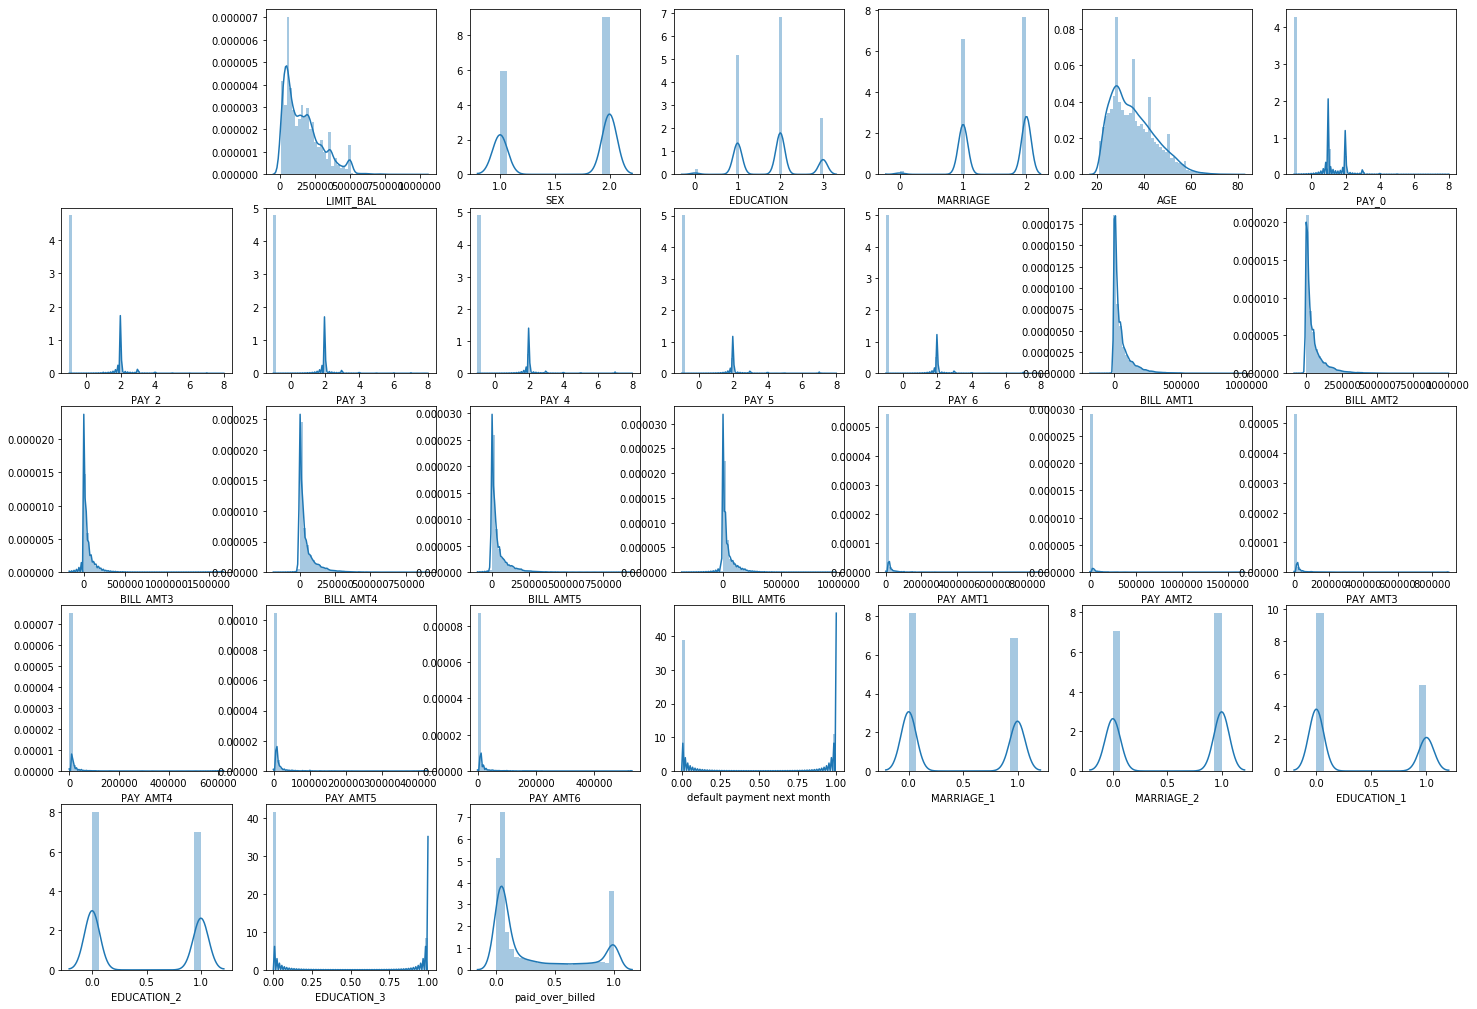

In [118]:

plt.figure(figsize=(25,25))
for i in range(1,len(df.columns)):
    plt.subplot(7, 7, i+1)
    sns.distplot(df[df.columns[i]])
plt.show()

In [ ]:
features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default payment next month', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3']

plt.figure(figsize=(50,50))
for i in range(0, len(features)):
    plt.subplot(4, 4, i + 1)
    sns.countplot(df[features[i]])
    plt.title(features[i])
plt.show()

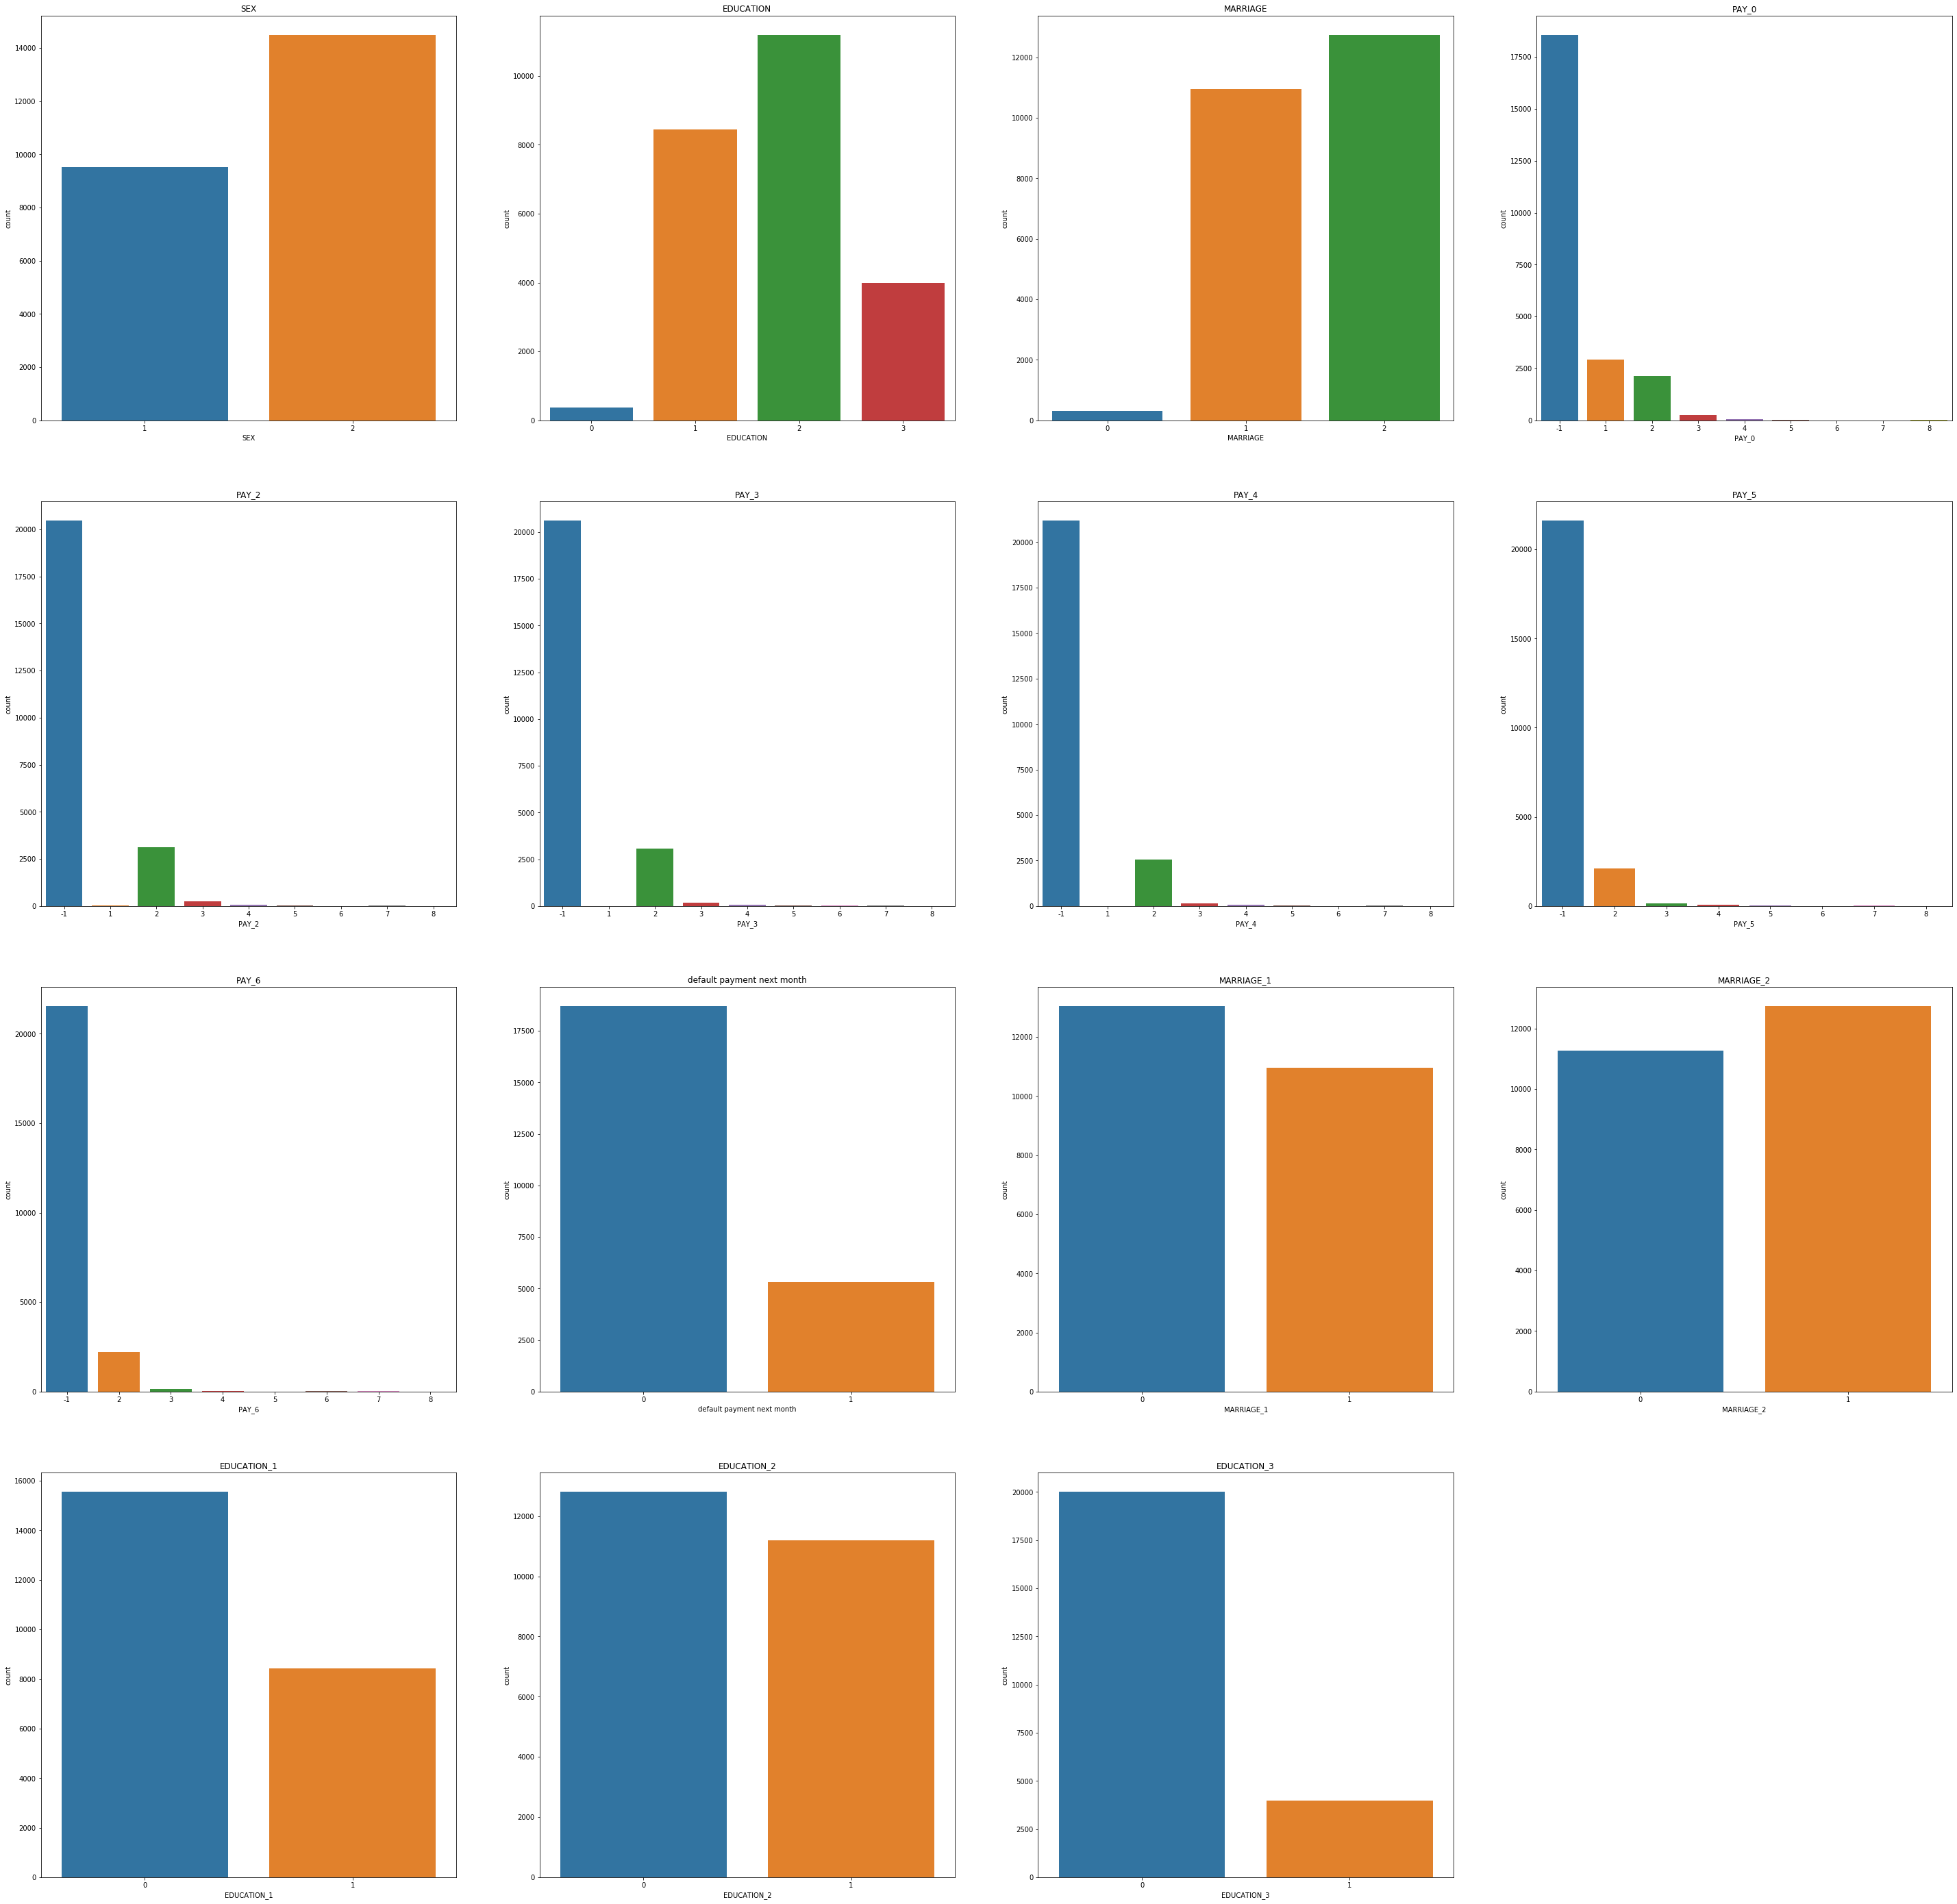

In [41]:
features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default payment next month', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3']

plt.figure(figsize=(50,50))
for i in range(0, len(features)):
    plt.subplot(4, 4, i + 1)
    sns.countplot(df[features[i]])
    plt.title(features[i])
plt.show()

In [42]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3'],
      dtype='object')

## 3. Feature Engineering

In [117]:
#percentage of total bill paid over time frame
bills = abs(df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'] + 1)
payments = abs(df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'])

df["percent_bill_paid"] = payments / bills
df['percent_bill_paid'] = df['percent_bill_paid'].apply(lambda x : 1 if x > 1 else x)  


In [102]:
df['percent_bill_paid'] = df['percent_bill_paid'].apply(lambda x : 1 if x > 1 else x)
#ambda x: 'value if condition is met' if x condition else 'value if condition is not met'

((23999,), (23999, 38))

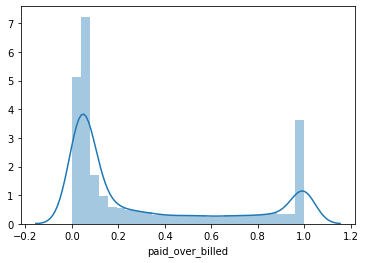

In [105]:
sns.distplot(df['paid_over_billed'])


In [50]:
# from itertools import combinations
# features_list = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
#        'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
#        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
#        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# df_others = df.drop(columns='default payment next month')
# target = 'dpnm'
# df['dpnm'] = df['default payment next month']
# combs = list(combinations(features_list, 2))
# comb_rsquared_dict = {}
# for c in range(0, len(combs)):
#     if (combs[c][0] == target or combs[c][1] == target):
#         continue
#     form_str = "{}~".format(target) + combs[c][0] + "*"  + combs[c][1]
#     lin = ols(formula=form_str, data=df).fit()
#     comb_rsquared_dict[combs[c][0] + '' + combs[c][1]] = lin.rsquared
# comb_rsquared_dict 
#sns.distplot(list(comb_rsquared_dict.values()))
#list(comb_rsquared_dict.values())
# count = 0
# for i in list(comb_rsquared_dict.values()):
#     if (i > 0.17):
#         print("{}".format(count))
#     count += 1
# print(max(list(comb_rsquared_dict.values())))

{'LIMIT_BALSEX': 0.02470526748796109,
 'LIMIT_BALEDUCATION': 0.02487584770770035,
 'LIMIT_BALMARRIAGE': 0.024925026796856264,
 'LIMIT_BALAGE': 0.025193744705784837,
 'LIMIT_BALPAY_0': 0.16454838333554422,
 'LIMIT_BALPAY_2': 0.11771377495576307,
 'LIMIT_BALPAY_3': 0.095739002631405,
 'LIMIT_BALPAY_4': 0.08692202913025016,
 'LIMIT_BALPAY_5': 0.08096475780837786,
 'LIMIT_BALPAY_6': 0.07343922054742102,
 'LIMIT_BALBILL_AMT1': 0.02552421279165107,
 'LIMIT_BALBILL_AMT2': 0.025349989871307654,
 'LIMIT_BALBILL_AMT3': 0.025167139957369744,
 'LIMIT_BALBILL_AMT4': 0.025335093709101253,
 'LIMIT_BALBILL_AMT5': 0.025564471269965527,
 'LIMIT_BALBILL_AMT6': 0.025447545016033857,
 'LIMIT_BALPAY_AMT1': 0.02667736335882298,
 'LIMIT_BALPAY_AMT2': 0.02594581441895205,
 'LIMIT_BALPAY_AMT3': 0.024662716250170136,
 'LIMIT_BALPAY_AMT4': 0.02513993387543345,
 'LIMIT_BALPAY_AMT5': 0.024643387867268163,
 'LIMIT_BALPAY_AMT6': 0.024803223388988882,
 'SEXEDUCATION': 0.006314369710146428,
 'SEXMARRIAGE': 0.0024151448

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()


## 6. Model Evaluation

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           scale_pos_weight= titanic['Survived'].mean(),
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

In [ ]:
from sklearn.utils import resample

training  = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
not_defaulted = training[training['default payment next month']==0]
defaulted = training[training['default payment next month']==1]

# upsample minority
defaulted_upsampled = resample(defaulted,
                          replace=True, # sample with replacement
                          n_samples=len(not_defaulted), # match number in majority class
                          random_state=23) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_defaulted, defaulted_upsampled])

# check new class counts
upsampled['default payment next month'].value_counts()


## 7. Final Model

In [20]:
#Given: list of prediction Series
#Return: Series of determined predictions based on votes
def aggregate(y_preds):
    prediction_list = []
    for y in y_preds:
        prediction_list.append(np.array(y).tolist())
    length = len(prediction_list[0])
    n = len(prediction_list) # number of prediction vectors
    final_preds = []
    for y in range(0, length): # for each row
        ttl_score = 0
        for i in prediction_list: #for each column
            ttl_score += i[y]
        if (ttl_score > (n // 2)):
            final_preds.append(1)
        else:
            final_preds.append(0)
    return pd.Series(final_preds)
            
            

In [27]:
import numpy as np
import pandas as pd
series_list = []
series_list.append(pd.Series([1,0,1,1,1]))
series_list.append(pd.Series([0,0,1,0,1]))
series_list.append(pd.Series([1,0,0,0,1]))
series_list.append(pd.Series([0,0,1,1,1]))
series_list.append(pd.Series([1,1,1,1,1]))
aggs = aggregate(series_list)

In [28]:
aggs

0    1
1    0
2    1
3    1
4    1
dtype: int64